In [6]:
#This is an minimal example for the calculation of an optimal control input 
#to a coupled network of FitzHugh-Nagumo oscillators. In this example the control 
#task is to switch between predefined bistable states. For more precise documentationa 
#and for altering parameters please use the jupyter notebook file example.ibynb!

#The calculation of this example might take a few minutes.

#!/usr/bin/env python
# coding: utf-8

import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import functions as functions
from FRoptimize import FR_algorithm

import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm

goal='switch'
bifurcation='high'
switchfromto='hightolow' 
noise_strength= 0.0 
realizations=1
noise=0
parameters_low = functions.set_parameters(goal,'low',parentDir)
parameters_high = functions.set_parameters(goal,'high',parentDir)
# 10 nodes
n_nodes = 5
A = parameters_low['A'][:n_nodes,:n_nodes]
parameters_low['A'] = A
parameters_low['N'] = n_nodes
A = parameters_high['A'][:n_nodes,:n_nodes]
parameters_high['A'] = A
parameters_high['N'] = n_nodes

#Set dimensions
T= 300 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set parameters of the cost functional
I_p_in= 0.0005
I_p=np.zeros((tsteps,parameters_low['N']))
I_p[int(tsteps-25/dt):]=I_p_in*np.ones((int(25/dt),parameters_low['N']))
I_e= 0.1#1.0 
I_s= 0.0


#choose initial condition for control
control=-np.ones((tsteps,parameters_low['N']))*0.002
control=control.reshape(tsteps*parameters_low['N'])

ic_state_low=functions.set_random_initial_conds_for_nodes('low',noise_strength,tsteps,d,dt,parameters_low,realizations,noise)
ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)


In [7]:
def give_target(parameters,ic):
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']
    control=np.zeros((tsteps,N))

    target_state=functions.runge_kutta_FHN_network(ic, control,  tsteps , d , dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)[:,0,:]
    return target_state

target_output = give_target(parameters_low,ic_state_low)
node_ic = ic_state_high
#make dictionary with all parameters
args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters_high)

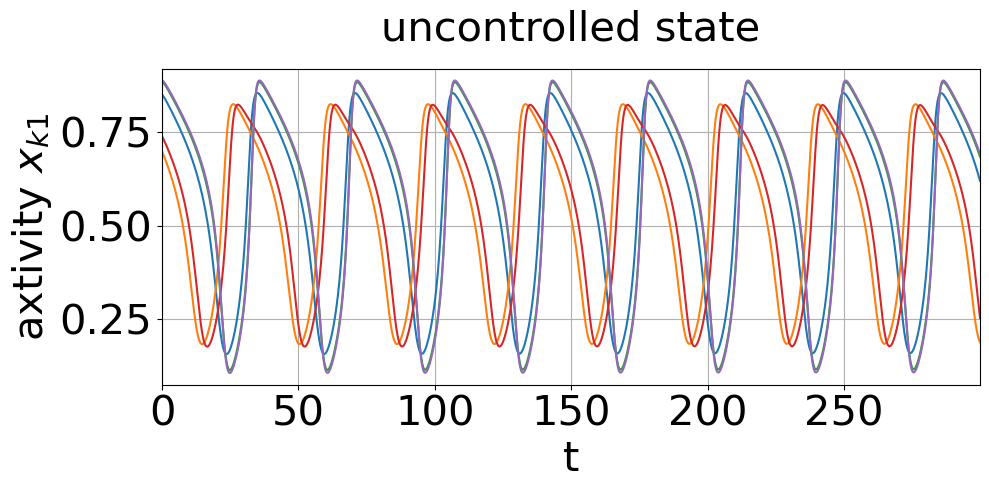

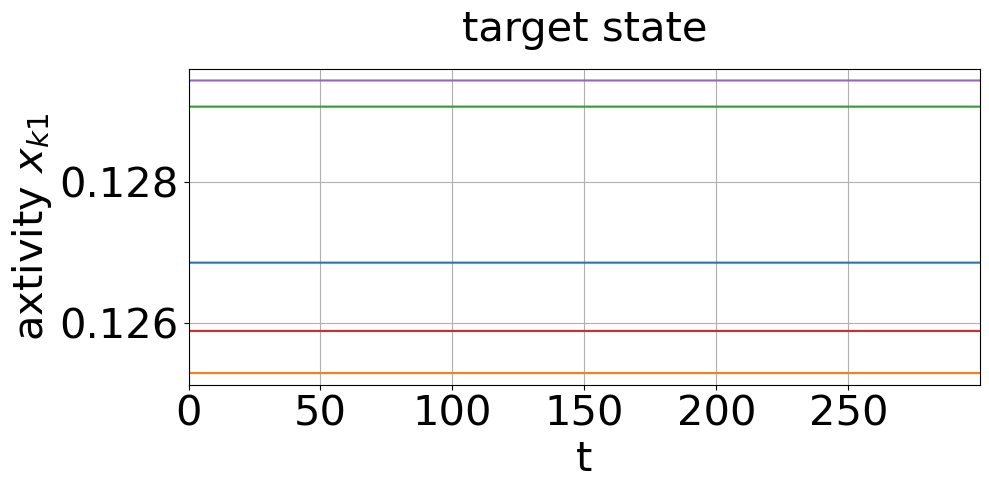

In [8]:
#In this case we want to find an optimal control that induces a switching 
#from an initial low state to a high target state. The uncontrolled state and 
#the target state are plotted:

def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=np.min(data)
    maxx=np.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(np.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

#calculate the uncontrolled state
nocontrol=np.zeros((tsteps,parameters_low['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

create_plot(state_uncontrolled[:,0,:],'axtivity $x_{k1}$','uncontrolled state')
plt.show()
create_plot(target_output,'axtivity $x_{k1}$','target state')
plt.show()

In [9]:
#To find the optimal control we define the cost functional and its gradient and start the optimization loop.

#define the functional and its gradient
functional=functions.f_switch
gradient=functions.fprime_switch

#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient, max_k=1000, **args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])

gnorm 8.929036979504908e-05 uknorm 1.3659732875431416e-06
Code finished after  289  iterations with warnflag 0


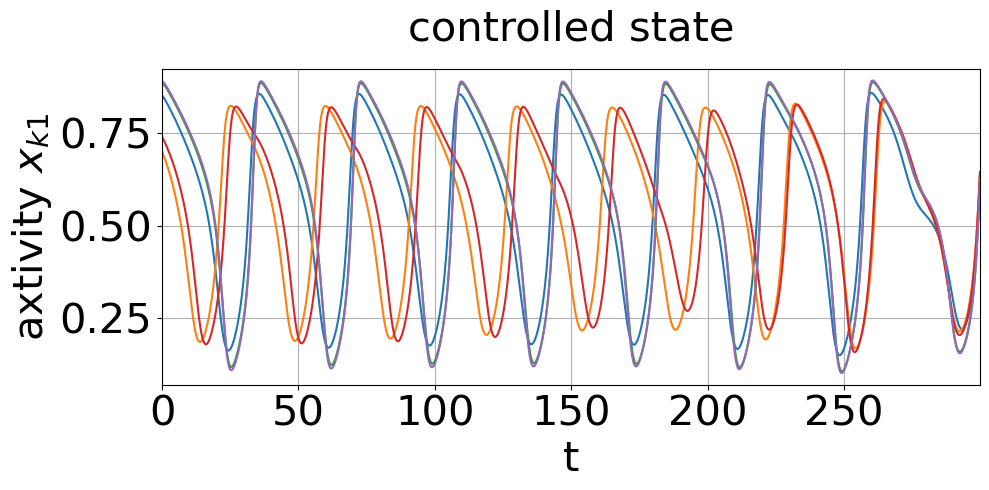

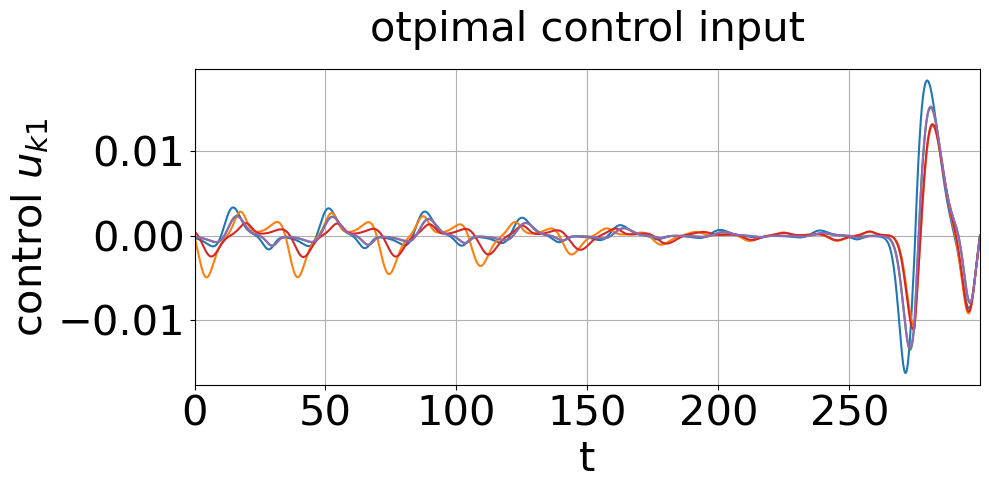

In [10]:
#The results can now be plottet:

#calculate the controlled state
control=control.reshape(tsteps,parameters_low['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)

create_plot(state_controlled[:,0,:],'axtivity $x_{k1}$','controlled state')
plt.show()
create_plot(control,'control $u_{k1}$','otpimal control input')
plt.show()


In [1]:
#This is an example of the calculation of an optimal control input 
#to a coupled network of FitzHugh-Nagumo oscillators.
#In this example the control task is to switch between predefined bistable states.

#The calculation of this example might take a few minutes.


#!/usr/bin/env python
# coding: utf-8

import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import functions as functions
from FRoptimize import FR_algorithm

import scipy.sparse as sp
import numpy as np
import pickle
import random
seed=50
random.seed(seed)


######################### SET PARAMETERS ############################

#set control goal: 
#can be "sync" (sync all nodes, use cost functional F_1), or "switch" (switch from ones state to a target state, use cost functional F_2
goal='switch'
#choose to simulate close to low or high bifurcation of the network dynamics in the state space
#needed for choosing the parameters sigma and mu
bifurcation='high'
#strenght of normalized gaussian white noise
noise_strength= 0.0 
#set network parameters
parameters = functions.set_parameters(goal,bifurcation,parentDir) # set node an network parameters: alpha,beta,gamma,delta,tau,epsilon,sigma,mu,A,N

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#if multiple realizations: set realization number
run=0

if goal=='switch':
    #set whether a switch from the low to high state or the opposite should be made
    #can be either 'lowtohigh' or 'hightolow'
    switchfromto='hightolow'#'lowtohigh' 
    #the presision is only penalized at the last 25 timeunits, to give the system time to switch
    I_p=np.zeros((tsteps,parameters['N']))
    I_p[int(tsteps-25/dt):]=I_p_in*np.ones((int(25/dt),parameters['N']))
elif goal=='sync':
    switchfromto='none'
    I_p=I_p_in
    
######################### INITIALIZATION ############################

#initialize noise if the noise-strenght is not zero:
if noise_strength !=0.0:
    realizations=20 #number of noise realizations over which to take the mean to calculate the cost functional
    noise=functions.initialize_noise(noise_strength,dt,realizations,tsteps,parameters['N'])
else:
    realizations=1
    noise=0

#choose initial condition for control, should not be 0 if I_s>0
control=-np.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

#Check that parameters are chosen correctly
functions.check_parameters(goal,bifurcation,switchfromto,noise_strength,I_p_in,I_e,I_s,control.reshape(tsteps,parameters['N']))

#initialize the node acivity and set target output
if goal=='sync': 
    # uuse random node inis
    node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
    #target output is a cross correlation of one for all pairs of nodes equal to one
    target_output=np.ones((parameters['N'],parameters['N']))

elif goal=='switch':  
    #read node inis from file, target_output is the state we want to switch to
    node_ic,target_output=functions.read_node_inis_from_file(bifurcation,switchfromto,fileDir,tsteps,d,dt,parameters)



#make dictionary with all parameters
args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)


######################### OPTIMIZATION ############################
#define the functional and its gradient
if noise_strength==0.0:
    if goal=='switch':
        functional=functions.f_switch
        gradient=functions.fprime_switch
    elif goal=='sync':
        functional=functions.f_sync
        gradient=functions.fprime_sync
else:
    functional=functions.f_sync_noisy
    gradient=functions.fprime_sync_noisy
    
    


[[0.74512083 0.7665178  0.84587683 0.84468795 0.78746369 0.79209181
  0.74454891 0.7790799  0.75356532 0.77564859 0.78682497 0.79563676
  0.77371145 0.7998424  0.7512717  0.76531792 0.776217   0.80257739
  0.80287298 0.80101211 0.76646035 0.80542126 0.76906556 0.77215765
  0.72981471 0.74735728 0.75905059 0.77364101 0.74768942 0.77434772
  0.73830628 0.76400539 0.81343269 0.81833603 0.79905541 0.82555695
  0.76947665 0.81987623 0.82363739 0.85348651 0.80793036 0.84565985
  0.75393068 0.77961656 0.75979049 0.83197796 0.80764463 0.83858961
  0.78582767 0.82137758 0.77268211 0.7986165  0.78953469 0.80513072
  0.80766668 0.77476637 0.74428728 0.74081902 0.76150679 0.79145076
  0.7620322  0.78686605 0.75657389 0.77668493 0.7520246  0.78411777
  0.73671161 0.7912335  0.72246094 0.77869071 0.85971578 0.88042688
  0.72290357 0.73766585 0.79530369 0.82725919 0.83982324 0.87517633
  0.7410346  0.7485126  0.80375561 0.81206213 0.72658131 0.76615175
  0.7721431  0.79722568 0.75797721 0.76971627 0.

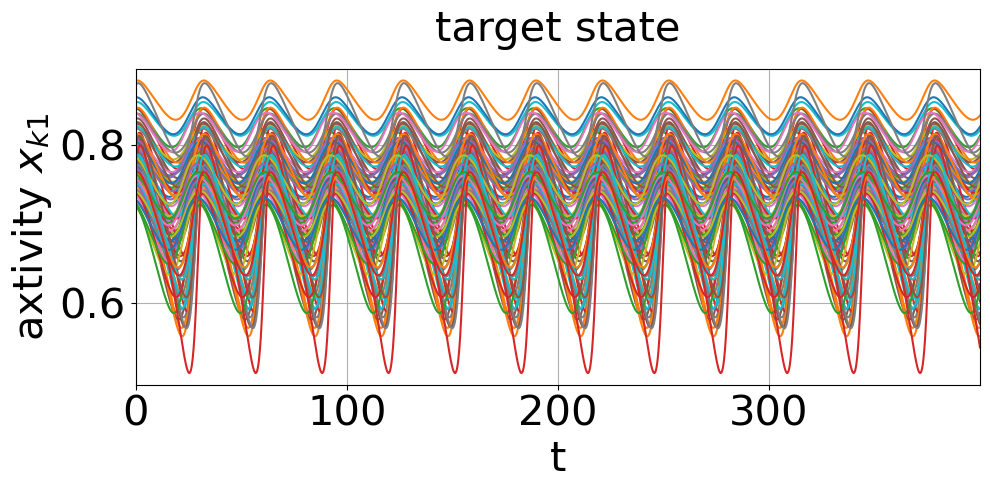

In [3]:
#In this case we want to find an optimal control that induces a switching 
#from an initial low state to a high target state. The uncontrolled state and 
#the target state are plotted:
import matplotlib.pyplot as plt
def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=np.min(data)
    maxx=np.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(np.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

create_plot(target_output,'axtivity $x_{k1}$','target state')
plt.show()

In [4]:
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
while warnflag == 1 and iteration<5000:
    
    result = FR_algorithm(functional, control, gradient,**args)

    control=result[0]
    warnflag=result[2]
    iteration+=result[4]
    
    #make dictionary to save the result
    out={
        'optimal_control':control.reshape(tsteps,parameters['N']),
        'functional':result[1],
        'gradient_norm':result[3],
        'warnflag':result[2],
        'iterations':iteration,
        'node_ic':node_ic,
        'target_output':target_output,
        'external_current':parameters['mu'],
        'coupling_strength':parameters['sigma'],
        'noise_strength':noise_strength,
        'noise':noise,
        'I_p':I_p,
        'I_e':I_e,
        'I_s':I_s,
        'T':T,
        'bifurcation':bifurcation,
        'goal':goal
        }
    
    print('Iteration ',iteration,' finished at gnorm',result[3],'with f',result[1],'with warnflag',result[2])


 #   outfile = open('filename','wb')
  #  pickle.dump(out,outfile)   
   # outfile.close()

print('Code finished after ',iteration,' iterations with warnflag',result[2])

gnorm 4.229225121702611e-05 uknorm 4.3264396131113586e-05
Iteration  63  finished at gnorm 4.229225121702611e-05 with f 0.015136025345724214 with warnflag 0
Code finished after  63  iterations with warnflag 0


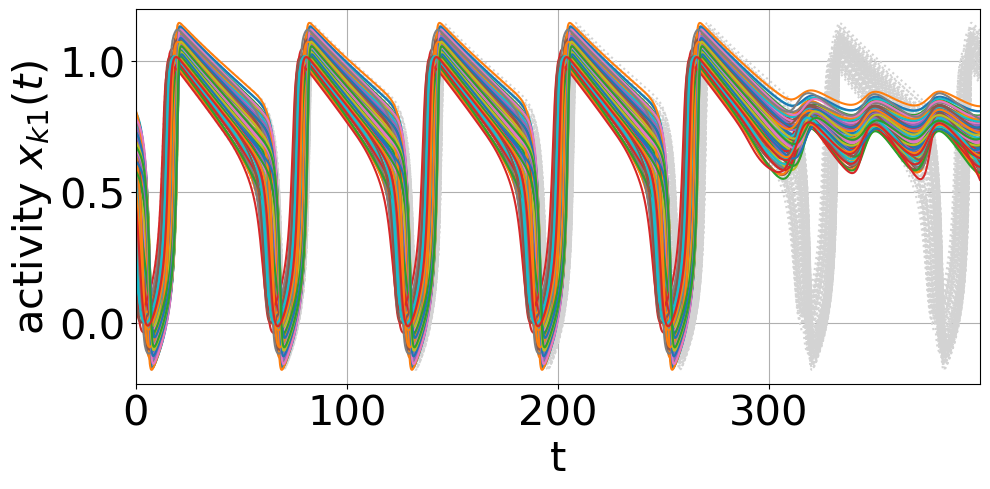

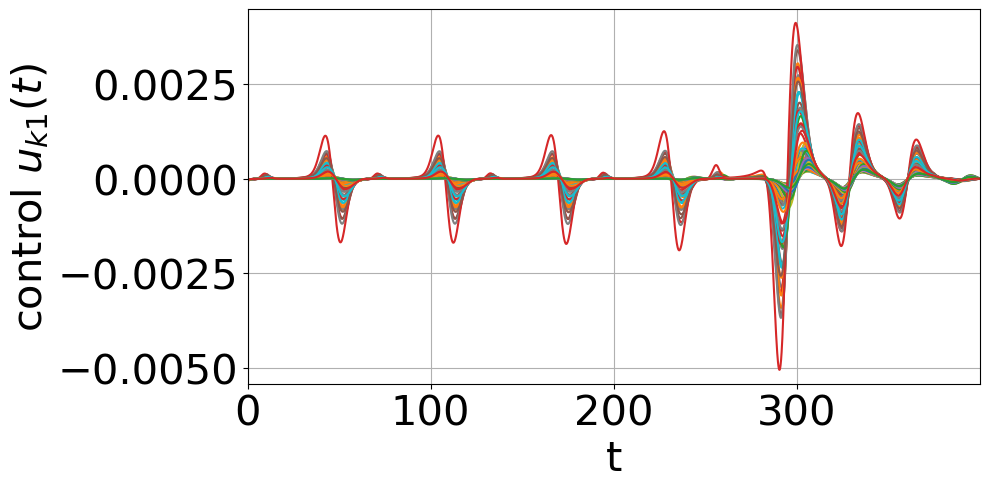

In [5]:
######################### PLOT THE RESULTS ############################


import matplotlib.pyplot as plt
from pylab import figure, cm


#calculate the controlled and uncontrolled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)
nocontrol=np.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

#make plot
fs=30 #fontsize
i=-1
# PLOT NETWORK STATE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(state_controlled[:,0,:])
maxx=np.max(state_controlled[:,0,:])
add=(maxx-minn)/25
im1=ax.plot(np.arange(0,int(T),dt),state_uncontrolled[:,0,:],color='lightgray',linestyle='dotted')
ax.plot(np.arange(0,int(T),dt),state_controlled[:,0,:])
ax.set_xlabel('t',size=fs)
ax.set_ylabel('activity $x_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Network state',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


# PLOT CORRESPONDING OPTIMAL CONTROL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(control)
maxx=np.max(control)
add=(maxx-minn)/25

im1=ax.plot(np.arange(0,int(T),dt),control)
ax.set_xlabel('t',size=fs)
ax.set_ylabel('control $u_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Control',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()




In [1]:
#This is an example of the calculation of an optimal control input 
#to a coupled network of FitzHugh-Nagumo oscillators.
#In this example the control task is to switch between predefined bistable states.

#The calculation of this example might take a few minutes.


#!/usr/bin/env python
# coding: utf-8

import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import functions as functions
from FRoptimize import FR_algorithm

import scipy.sparse as sp
import numpy as np
import pickle
import random
seed=50
random.seed(seed)


######################### SET PARAMETERS ############################

#set control goal: 
#can be "sync" (sync all nodes, use cost functional F_1), or "switch" (switch from ones state to a target state, use cost functional F_2
goal='sync'
#choose to simulate close to low or high bifurcation of the network dynamics in the state space
#needed for choosing the parameters sigma and mu
bifurcation='high'
#strenght of normalized gaussian white noise
noise_strength= 0.0 
#set network parameters
parameters = functions.set_parameters(goal,bifurcation,parentDir) # set node an network parameters: alpha,beta,gamma,delta,tau,epsilon,sigma,mu,A,N
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
parameters['A'] = A
parameters['N'] = n_nodes
#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#if multiple realizations: set realization number
run=0

if goal=='switch':
    #set whether a switch from the low to high state or the opposite should be made
    #can be either 'lowtohigh' or 'hightolow'
    switchfromto='hightolow'#'lowtohigh' 
    #the presision is only penalized at the last 25 timeunits, to give the system time to switch
    I_p=np.zeros((tsteps,parameters['N']))
    I_p[int(tsteps-25/dt):]=I_p_in*np.ones((int(25/dt),parameters['N']))
elif goal=='sync':
    switchfromto='none'
    I_p=I_p_in
    
######################### INITIALIZATION ############################

#initialize noise if the noise-strenght is not zero:
if noise_strength !=0.0:
    realizations=20 #number of noise realizations over which to take the mean to calculate the cost functional
    noise=functions.initialize_noise(noise_strength,dt,realizations,tsteps,parameters['N'])
else:
    realizations=1
    noise=0

#choose initial condition for control, should not be 0 if I_s>0
control=-np.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

#Check that parameters are chosen correctly
functions.check_parameters(goal,bifurcation,switchfromto,noise_strength,I_p_in,I_e,I_s,control.reshape(tsteps,parameters['N']))
 

#initialize the node acivity and set target output
if goal=='sync': 
    # uuse random node inis
    node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
    #target output is a cross correlation of one for all pairs of nodes equal to one
    target_output=np.ones((parameters['N'],parameters['N']))

    
elif goal=='switch':  
    #read node inis from file, target_output is the state we want to switch to
    node_ic,target_output=functions.read_node_N(bifurcation,switchfromto,fileDir,tsteps,d,dt,parameters)



#make dictionary with all parameters
args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)


######################### OPTIMIZATION ############################
#define the functional and its gradient
if noise_strength==0.0:
    if goal=='switch':
        functional=functions.f_switch
        gradient=functions.fprime_switch
    elif goal=='sync':
        functional=functions.f_sync
        gradient=functions.fprime_sync
else:
    functional=functions.f_sync_noisy
    gradient=functions.fprime_sync_noisy
    
    


/Users/shi/Desktop/individual/OptimalControl-master/src_and_example/functions.py:848: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  k1 = dt* ODE_FHN_network(x[ts],ts,control,tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


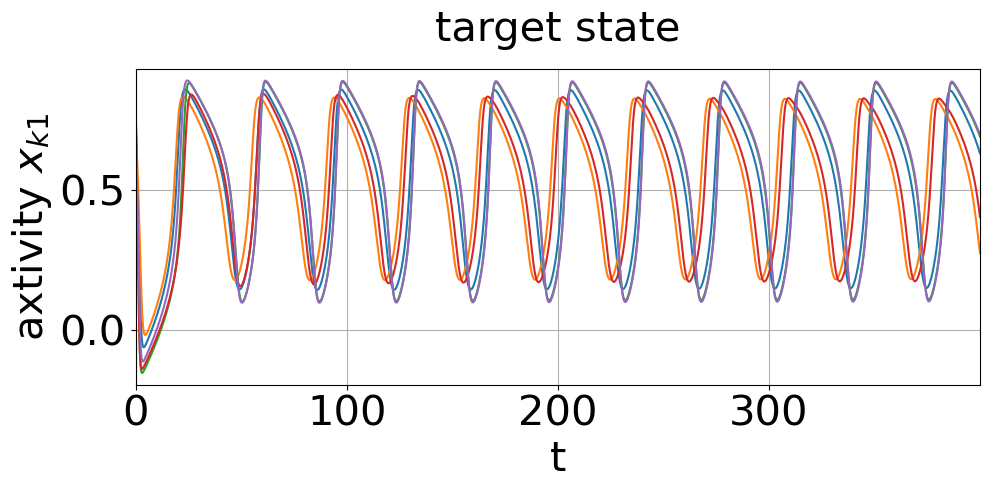

In [2]:
#In this case we want to find an optimal control that induces a switching 
#from an initial low state to a high target state. The uncontrolled state and 
#the target state are plotted:
import matplotlib.pyplot as plt
def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=np.min(data)
    maxx=np.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(np.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

create_plot(target_output,'axtivity $x_{k1}$','target state')
plt.show()

In [2]:
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
while warnflag == 1 and iteration<5000:
    
    result = FR_algorithm(functional, control, gradient,**args)

    control=result[0]
    warnflag=result[2]
    iteration+=result[4]
    
    #make dictionary to save the result
    out={
        'optimal_control':control.reshape(tsteps,parameters['N']),
        'functional':result[1],
        'gradient_norm':result[3],
        'warnflag':result[2],
        'iterations':iteration,
        'node_ic':node_ic,
        'target_output':target_output,
        'external_current':parameters['mu'],
        'coupling_strength':parameters['sigma'],
        'noise_strength':noise_strength,
        'noise':noise,
        'I_p':I_p,
        'I_e':I_e,
        'I_s':I_s,
        'T':T,
        'bifurcation':bifurcation,
        'goal':goal
        }
    
    print('Iteration ',iteration,' finished at gnorm',result[3],'with f',result[1],'with warnflag',result[2])


 #   outfile = open('filename','wb')
  #  pickle.dump(out,outfile)   
   # outfile.close()

print('Code finished after ',iteration,' iterations with warnflag',result[2])

[0.00263155 0.00250854 0.0074145  ... 0.002      0.002      0.002     ]
[-0.00212751 -0.00190428 -0.00961967 ... -0.001125   -0.001125
 -0.001125  ]
[0.00266561 0.00278688 0.00588964 ... 0.00239777 0.00239777 0.00239777]
[1.36100331e-04 2.29743963e-04 1.37818755e-03 ... 3.56685517e-05
 3.56685517e-05 3.56685517e-05]
[-2.80478197e-05 -3.13909982e-04 -2.59185880e-03 ... -3.03561063e-04
 -3.03561063e-04 -3.03561063e-04]
[-0.00044219 -0.00039338 -0.00021333 ... -0.00036999 -0.00036999
 -0.00036999]
[-5.23551045e-03 -1.85647709e-06 -5.57637544e-03 ... -1.29825930e-05
 -1.29825930e-05 -1.29825930e-05]
[-0.00336061 -0.00332894 -0.00241473 ... -0.0028784  -0.0028784
 -0.0028784 ]
[ 1.23269587e-03 -2.00595917e-04  9.58196754e-04 ...  2.27880152e-05
  2.27880152e-05  2.27880152e-05]
[9.63902550e-04 3.60624991e-05 1.79175124e-03 ... 3.84352891e-05
 3.84352891e-05 3.84352891e-05]
[-8.29213657e-04  1.74617954e-04  2.77273054e-04 ...  2.64000224e-05
  2.64000224e-05  2.64000224e-05]
[-4.52940425e-04

[ 1.98139681e-04 -2.58494229e-05 -2.56562804e-04 ...  1.19897192e-06
  1.19897192e-06  1.19897192e-06]
[-2.00652666e-05 -1.53191901e-06  6.42239189e-04 ...  3.29641114e-07
  3.29641114e-07  3.29641114e-07]
[ 5.43156396e-05 -6.93167775e-06 -1.07987241e-04 ...  3.25617174e-07
  3.25617174e-07  3.25617174e-07]
[ 2.38445944e-04 -4.06120772e-05  9.79876576e-04 ...  2.56579520e-06
  2.56579520e-06  2.56579520e-06]
[ 1.02378105e-04 -9.68906328e-06 -9.65365370e-04 ...  2.47076414e-07
  2.47076414e-07  2.47076414e-07]
[ 2.12565700e-04 -3.67871926e-05  7.93527219e-04 ...  2.44419641e-06
  2.44419641e-06  2.44419641e-06]
[ 1.06266256e-03 -1.80600896e-04  3.38370512e-03 ...  1.19455415e-05
  1.19455415e-05  1.19455415e-05]
[ 4.24189688e-05 -4.03479135e-06 -4.24957632e-04 ...  2.14223965e-07
  2.14223965e-07  2.14223965e-07]
[ 2.31397467e-06 -9.54456227e-07 -5.18057921e-06 ...  2.56052210e-07
  2.56052210e-07  2.56052210e-07]
[2.94987699e-05 3.08534626e-06 4.62079762e-04 ... 1.11588529e-07
 1.11588

In [5]:
result[5]

[0.09432157271236205,
 0.0731676585679958,
 0.04563939863204532,
 0.03280287618297647,
 0.03051469869237264,
 0.02782051599813937,
 0.02113351395453701,
 0.014369970820956729,
 0.01210252301636558,
 0.008061463444779518,
 0.00796891644079134,
 0.007795908479114615,
 0.0075742644540375305,
 0.004616656294745863,
 0.004334964681675319,
 0.004298724328163092,
 0.0035906640592126707,
 0.0033463191767540423,
 0.003285477172943764,
 0.0032611938581039515,
 0.003243703326105818,
 0.0032248918135861543,
 0.003224358465219056,
 0.003214247941410191,
 0.0032084971955049415,
 0.003206840278672448,
 0.003206070437811786,
 0.003205214053177284,
 0.003204749545063038]

In [6]:
result[6]

[array([-0.00254017, -0.00083921, -0.00244032, ..., -0.002     ,
        -0.002     , -0.002     ]),
 array([0.00193125, 0.00030864, 0.00137908, ..., 0.001125  , 0.001125  ,
        0.001125  ]),
 array([-0.00239203, -0.00056933, -0.0031124 , ..., -0.00063281,
        -0.00063281, -0.00063281]),
 array([ 0.00034284, -0.00029399,  0.00173167, ...,  0.00065482,
         0.00065482,  0.00065482]),
 array([0.00202   , 0.00098664, 0.00287731, ..., 0.00109818, 0.00109818,
        0.00109818]),
 array([0.00173106, 0.00163233, 0.00127682, ..., 0.00079932, 0.00079932,
        0.00079932]),
 array([-0.00070493, -0.00103631, -0.00123635, ..., -0.00021271,
        -0.00021271, -0.00021271]),
 array([-0.00160148, -0.00169829, -0.00152839, ..., -0.00054091,
        -0.00054091, -0.00054091]),
 array([-0.00131628, -0.00054316, -0.00123535, ..., -0.00056089,
        -0.00056089, -0.00056089]),
 array([ 0.00110629,  0.00021289,  0.00044386, ..., -0.00012269,
        -0.00012269, -0.00012269]),
 array([

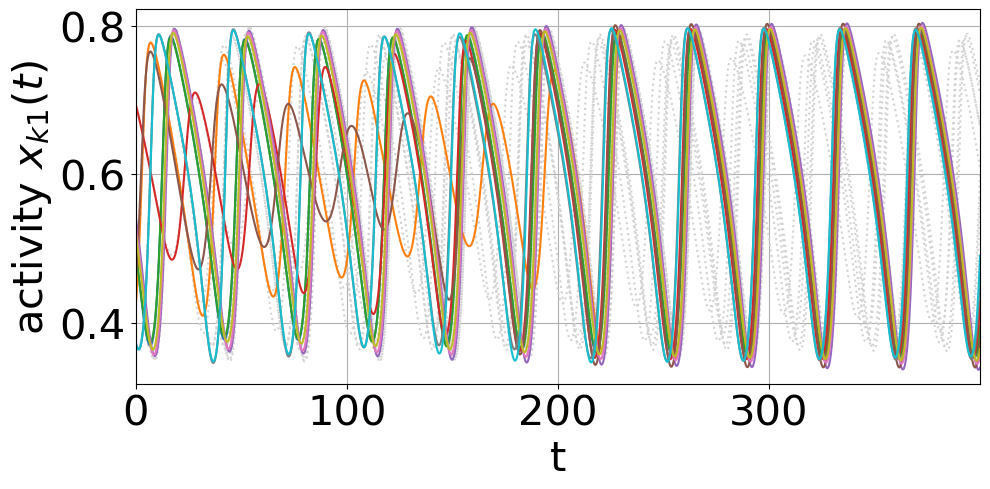

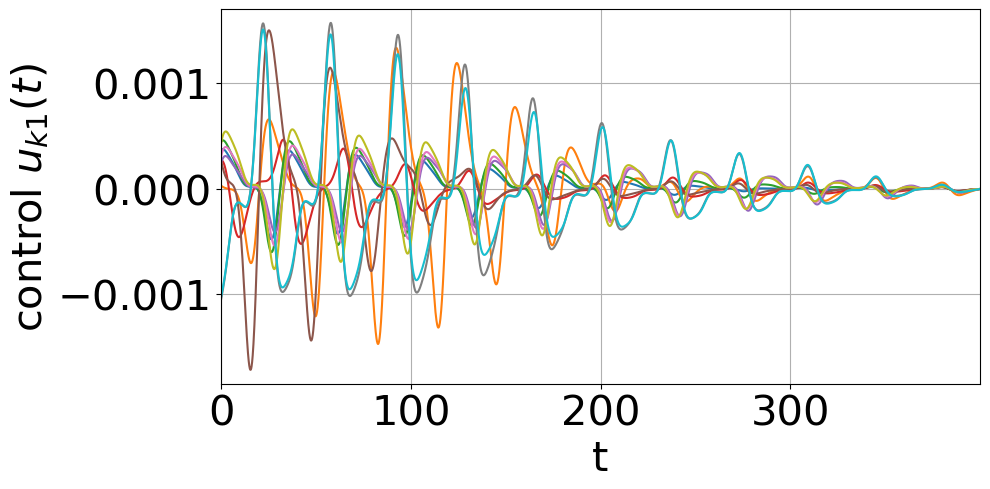

In [3]:
######################### PLOT THE RESULTS ############################


import matplotlib.pyplot as plt
from pylab import figure, cm


#calculate the controlled and uncontrolled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)
nocontrol=np.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

#make plot
fs=30 #fontsize
i=-1
# PLOT NETWORK STATE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(state_controlled[:,0,:])
maxx=np.max(state_controlled[:,0,:])
add=(maxx-minn)/25
im1=ax.plot(np.arange(0,int(T),dt),state_uncontrolled[:,0,:],color='lightgray',linestyle='dotted')
ax.plot(np.arange(0,int(T),dt),state_controlled[:,0,:])
ax.set_xlabel('t',size=fs)
ax.set_ylabel('activity $x_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Network state',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


# PLOT CORRESPONDING OPTIMAL CONTROL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(control)
maxx=np.max(control)
add=(maxx-minn)/25

im1=ax.plot(np.arange(0,int(T),dt),control)
ax.set_xlabel('t',size=fs)
ax.set_ylabel('control $u_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Control',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


